In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
# pip install faiss_cpu


Running Autoencoder...
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - loss: 0.0316 - val_loss: 0.0438 - learning_rate: 0.0010
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0110 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0082 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0070 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0062 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0057 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0053 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0050 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0047 - val_loss: 0.0053 

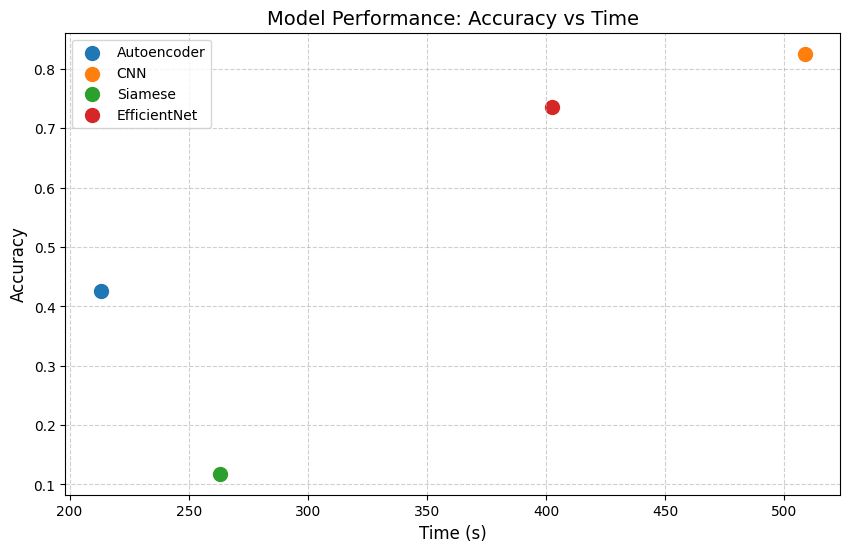

In [16]:
from typing import Tuple, List, Dict, Any
import numpy as np
import tensorflow as tf
import time
import psutil
import faiss
import torch
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Lambda, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from transformers import ViTFeatureExtractor, ViTModel
import tensorflow.keras.backend as K
import h5py
import gc
from concurrent.futures import ThreadPoolExecutor

class ImageSearch:
    def __init__(self, input_shape=(32, 32, 3), batch_size=256, epochs=20):
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.epochs = epochs
        self.feature_dimension = 512
        self.initialize_components()

    def initialize_components(self):
        """Initialize training components"""
        self.callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
            EarlyStopping(monitor='val_loss', patience=5),
            ModelCheckpoint('best_model.keras', save_best_only=True)
        ]
        self.datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            preprocessing_function=self.preprocessing
        )

    @staticmethod
    def preprocessing(image):
        """image preprocessing"""
        return tf.cast(image, tf.float32) / 255.0

    def batch_generator(self, images, batch_size=32):
        """batch generator"""
        num_samples = len(images)
        while True:
            indices = np.random.permutation(num_samples)
            for start_idx in range(0, num_samples, batch_size):
                end_idx = min(start_idx + batch_size, num_samples)
                yield images[indices[start_idx:end_idx]]

    def build_efficient_index(self, features: np.ndarray) -> faiss.Index:
        """Build FAISS index for similarity search"""
        # Convert to correct format
        features = features.astype(np.float32)

        # Normalize features
        faiss.normalize_L2(features)

        dimension = features.shape[1]

        # Choose index type based on dataset size
        if len(features) > 1000000:
            nlist = int(np.sqrt(len(features)))
            quantizer = faiss.IndexFlatL2(dimension)
            index = faiss.IndexIVFFlat(quantizer, dimension, nlist)
            index.train(features)
        else:
            index = faiss.IndexFlatL2(dimension)

        # Add vectors to index
        index.add(features)
        return index

    def search_similar(self, query_features: np.ndarray, index: faiss.Index, k: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        """Search for similar images"""
        # Prepare query features
        query_features = query_features.astype(np.float32)
        if query_features.ndim == 1:
            query_features = query_features.reshape(1, -1)

        # Normalize query features
        faiss.normalize_L2(query_features)

        # Perform search
        return index.search(query_features, k)


    # Autoencoder
    def efficient_feature_extraction(self, model, images: np.ndarray, batch_size=32) -> Tuple[np.ndarray, np.ndarray]:
      """Extract features efficiently using batches"""
      features = []

      @tf.function
      def process_batch(batch):
          return model(batch, training=False)

      for i in range(0, len(images), batch_size):
          batch = images[i:i + batch_size]
          batch_features = process_batch(batch)
          features.append(batch_features.numpy())
          gc.collect()

      return np.concatenate(features), None 

    def autoencoder_features(self, train_images: np.ndarray, val_images: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
      """Autoencoder implementation with fixed return values and improved architecture"""
      input_img = Input(shape=self.input_shape)

      # Encoder - with batch normalization and proper scaling
      x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
      x = tf.keras.layers.BatchNormalization()(x)
      x = MaxPooling2D((2, 2))(x)

      x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = MaxPooling2D((2, 2))(x)

      x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = Flatten()(x)

      # Bottleneck
      encoded = Dense(self.feature_dimension, activation='relu')(x)

      # Decoder
      x = Dense(128 * (self.input_shape[0]//4) * (self.input_shape[1]//4))(encoded)
      x = tf.keras.layers.Reshape((self.input_shape[0]//4, self.input_shape[1]//4, 128))(x)

      x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.UpSampling2D((2, 2))(x)

      x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.UpSampling2D((2, 2))(x)

      x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)

      decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

      # Create and compile models
      autoencoder = Model(input_img, decoded)
      encoder = Model(input_img, encoded)

      # Use MSE loss and Adam optimizer with a lower learning rate
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
      autoencoder.compile(optimizer=optimizer, loss='mse')

      # Normalize input data
      train_images_norm = train_images.astype('float32') / 255.0
      val_images_norm = val_images.astype('float32') / 255.0

      # Train with proper validation data
      history = autoencoder.fit(
          train_images_norm, train_images_norm,
          validation_data=(val_images_norm, val_images_norm),
          batch_size=self.batch_size,
          epochs=self.epochs,
          callbacks=self.callbacks,
          shuffle=True
      )

      # Extract features using the encoder
      train_features = encoder.predict(train_images_norm, batch_size=self.batch_size)
      val_features = encoder.predict(val_images_norm, batch_size=self.batch_size)

      return train_features, val_features

    # CNN (ResNet50)
    def cnn_features(self, train_images: np.ndarray, val_images: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
      """CNN feature extraction with progress tracking and timeout protection"""

      def create_model():
          base_model = ResNet50(
              weights='imagenet',
              include_top=False,
              input_shape=(224, 224, 3),
              pooling='avg'
          )

          # Freeze base model
          base_model.trainable = False

          inputs = Input(shape=(224, 224, 3))
          x = base_model(inputs)
          x = Dense(self.feature_dimension, activation='relu')(x)
          return Model(inputs=inputs, outputs=x)

      @tf.function(reduce_retracing=True)
      def process_single_batch(model, batch):
          """Process a single batch with TF function decoration"""
          return model(batch, training=False)

      def process_batch_with_timeout(model, images: np.ndarray, batch_size: int = 16) -> np.ndarray:
          """Process images in small batches with progress tracking and timeout protection"""
          features = []
          total_batches = (len(images) + batch_size - 1) // batch_size

          for i in range(0, len(images), batch_size):
              if i % (batch_size * 10) == 0:
                  print(f"Processing batch {i//batch_size + 1}/{total_batches}")

              batch = images[i:i + batch_size]

              if len(batch) < batch_size:
                  # Pad the batch to maintain consistent size
                  pad_size = batch_size - len(batch)
                  batch = np.pad(batch, ((0, pad_size), (0, 0), (0, 0), (0, 0)), mode='constant')

              # Resize and preprocess
              batch_resized = tf.image.resize(batch, (224, 224))
              batch_preprocessed = tf.keras.applications.resnet50.preprocess_input(batch_resized)

              # Get features
              try:
                  batch_features = process_single_batch(model, batch_preprocessed).numpy()

                  # If we padded the batch, remove the padding from features
                  if len(batch) < batch_size:
                      batch_features = batch_features[:len(images) - i]

                  features.append(batch_features)

              except Exception as e:
                  print(f"Error processing batch: {e}")
                  continue

              # Clear memory
              if i % (batch_size * 10) == 0:
                  gc.collect()

          return np.vstack(features)

      # Set memory growth
      try:
          gpus = tf.config.experimental.list_physical_devices('GPU')
          if gpus:
              for gpu in gpus:
                  tf.config.experimental.set_memory_growth(gpu, True)
      except Exception as e:
          print(f"GPU configuration error: {e}")

      print("Creating model...")
      model = create_model()

      # Ensure model is built
      model.build((None, 224, 224, 3))

      # Use smaller batch size and add progress tracking
      batch_size = 8  # Reduced batch size
      print(f"Total training samples: {len(train_images)}")
      print(f"Batch size: {batch_size}")
      print(f"Expected batches: {len(train_images) // batch_size + 1}")

      print("Processing training images...")
      train_features = process_batch_with_timeout(model, train_images, batch_size=batch_size)

      print("Processing validation images...")
      val_features = process_batch_with_timeout(model, val_images, batch_size=batch_size)

      # Cleanup
      del model
      gc.collect()
      tf.keras.backend.clear_session()

      return train_features, val_features

    # Siamese Network
    def siamese_features(self, train_images: np.ndarray, val_images: np.ndarray, train_labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
      """Memory-optimized Siamese network implementation with batch processing"""

      def create_base_network():
          """Lighter base network with BatchNormalization"""
          input_layer = Input(shape=self.input_shape)
          x = tf.keras.layers.BatchNormalization()(input_layer)

          # First conv block
          x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
          x = tf.keras.layers.BatchNormalization()(x)
          x = MaxPooling2D((2, 2))(x)

          # Second conv block
          x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
          x = tf.keras.layers.BatchNormalization()(x)
          x = MaxPooling2D((2, 2))(x)

          # Dense layers
          x = Flatten()(x)
          x = Dense(512, activation='relu')(x)
          x = tf.keras.layers.BatchNormalization()(x)
          x = tf.keras.layers.Dropout(0.5)(x)

          return Model(input_layer, x)

      def create_pairs_batch(images, labels, batch_size=1000):
          """Create pairs in batches to avoid memory issues"""
          pairs = []
          pair_labels = []

          # Get unique labels
          unique_labels = np.unique(labels)
          label_to_indices = {label: np.where(labels == label)[0] for label in unique_labels}

          pairs_per_label = batch_size // len(unique_labels)

          for label in unique_labels:
              positive_indices = label_to_indices[label]
              if len(positive_indices) < 2:
                  continue

              # Create positive pairs
              pos_pairs = np.random.choice(positive_indices, size=(min(pairs_per_label, len(positive_indices) - 1), 2))
              pairs.extend([[images[i], images[j]] for i, j in pos_pairs])
              pair_labels.extend([1] * len(pos_pairs))

              # Create negative pairs
              negative_labels = [l for l in unique_labels if l != label]
              for _ in range(min(pairs_per_label, len(positive_indices))):
                  neg_label = np.random.choice(negative_labels)
                  neg_idx = np.random.choice(label_to_indices[neg_label])
                  pos_idx = np.random.choice(positive_indices)
                  pairs.append([images[pos_idx], images[neg_idx]])
                  pair_labels.append(0)

          return np.array(pairs), np.array(pair_labels)

      try:
          # Configure GPU memory growth
          gpus = tf.config.experimental.list_physical_devices('GPU')
          if gpus:
              for gpu in gpus:
                  tf.config.experimental.set_memory_growth(gpu, True)
      except Exception as e:
          print(f"GPU configuration error: {e}")

      # Create and compile models
      base_network = create_base_network()

      input_a = Input(shape=self.input_shape)
      input_b = Input(shape=self.input_shape)

      feat_a = base_network(input_a)
      feat_b = base_network(input_b)

      distance = Lambda(lambda x: K.abs(x[0] - x[1]))([feat_a, feat_b])
      outputs = Dense(1, activation='sigmoid')(distance)

      siamese_model = Model(inputs=[input_a, input_b], outputs=outputs)

      optimizer = tf.keras.optimizers.Adam(
          learning_rate=0.0001,
          clipnorm=1.0
      )

      siamese_model.compile(
          loss='binary_crossentropy',
          optimizer=optimizer,
          metrics=['accuracy']
      )

      # Normalize input images
      train_images = train_images.astype('float32') / 255.0

      # Train in batches
      batch_size = 32  # Reduced batch size
      train_steps = len(train_labels) // batch_size

      for epoch in range(self.epochs):
          print(f"\nEpoch {epoch + 1}/{self.epochs}")

          # Create pairs for this epoch
          pairs, pair_labels = create_pairs_batch(
              train_images,
              train_labels.flatten(),
              batch_size=10000 
          )

          # Train on this batch of pairs
          history = siamese_model.fit(
              [pairs[:, 0], pairs[:, 1]],
              pair_labels,
              batch_size=batch_size,
              epochs=1,
              validation_split=0.1,
              callbacks=self.callbacks
          )

          # Clear memory
          gc.collect()
          tf.keras.backend.clear_session()

      # Extract features
      print("\nExtracting features...")
      train_features = []
      val_features = []

      # Process training images in batches
      for i in range(0, len(train_images), batch_size):
          batch = train_images[i:i + batch_size]
          features = base_network.predict(batch, verbose=0)
          train_features.append(features)

      # Process validation images in batches
      for i in range(0, len(val_images), batch_size):
          batch = val_images[i:i + batch_size]
          features = base_network.predict(batch, verbose=0)
          val_features.append(features)

      # Cleanup
      del siamese_model
      del base_network
      gc.collect()
      tf.keras.backend.clear_session()

      return np.vstack(train_features), np.vstack(val_features)
    
    # EfficientNet Implementation
    def efficientnet_features(self, train_images: np.ndarray, val_images: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
      """Memory-optimized EfficientNet feature extraction to prevent crashes"""
      try:
          def create_model():
              base_model = EfficientNetB0(
                  weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3)
              )
              x = base_model.output
              x = GlobalAveragePooling2D()(x)
              x = Dense(512, activation='relu')(x)
              outputs = Dense(self.feature_dimension, activation='relu')(x)
              return Model(inputs=base_model.input, outputs=outputs)

          def preprocess_images_generator(images: np.ndarray, batch_size: int = 32):
              """Yield preprocessed image batches to avoid loading all into memory"""
              for i in range(0, len(images), batch_size):
                  batch = images[i:i + batch_size]
                  batch_resized = np.array([tf.image.resize(img, (224, 224)).numpy() for img in batch])
                  yield tf.keras.applications.efficientnet.preprocess_input(batch_resized)

          def extract_features_with_generator(model, image_generator, steps: int) -> np.ndarray:
              """Extract features using a generator to minimize memory usage"""
              features = []
              for i, batch in enumerate(image_generator):
                  print(f"Processing batch {i + 1}/{steps}")
                  batch_features = model.predict(batch, verbose=0)
                  features.append(batch_features)
              return np.vstack(features)

          print("Starting feature extraction...")

          # Clear initial memory
          tf.keras.backend.clear_session()
          gc.collect()

          print("Creating model...")
          model = create_model()

          print("\nProcessing and extracting training features...")
          train_gen = preprocess_images_generator(train_images, batch_size=16)
          train_steps = (len(train_images) + 15) // 16
          train_features = extract_features_with_generator(model, train_gen, train_steps)

          print("\nProcessing and extracting validation features...")
          val_gen = preprocess_images_generator(val_images, batch_size=16)
          val_steps = (len(val_images) + 15) // 16
          val_features = extract_features_with_generator(model, val_gen, val_steps)

          # Final cleanup
          del model
          gc.collect()
          tf.keras.backend.clear_session()

          return train_features, val_features

      except Exception as e:
          print(f"Error during feature extraction: {str(e)}")

    def parallel_image_resize(self, images: np.ndarray, size=224) -> np.ndarray:
        """Parallel image resizing"""
        def resize_single(img):
            return tf.image.resize(img, (size, size)).numpy()

        with ThreadPoolExecutor() as executor:
            resized = list(executor.map(resize_single, images))
        return np.array(resized)

    def create_pairs(self, images: np.ndarray, labels: np.ndarray):
        """Create pairs for Siamese network training"""
        pairs = []
        pair_labels = []

        # Create dictionary of indices for each class
        class_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}

        # Create positive and negative pairs
        for label in class_indices:
            positive_indices = class_indices[label]
            negative_labels = [l for l in class_indices.keys() if l != label]

            # Create positive pairs
            for i in range(len(positive_indices) - 1):
                pairs.append([images[positive_indices[i]], images[positive_indices[i + 1]]])
                pair_labels.append(1)

                # Create negative pair
                neg_label = np.random.choice(negative_labels)
                neg_idx = np.random.choice(class_indices[neg_label])
                pairs.append([images[positive_indices[i]], images[neg_idx]])
                pair_labels.append(0)

        return np.array(pairs), np.array(pair_labels)

def main():
    searcher = ImageSearch()

    # Load and prepare data
    (x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32')

    # Split data
    train_images, val_images, train_labels, val_labels = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    methods = {
        'Autoencoder': searcher.autoencoder_features,
        'CNN': searcher.cnn_features,
        'Siamese': searcher.siamese_features,
        'EfficientNet': searcher.efficientnet_features
    }

    results = {}

    # Run all methods
    for method_name, method_fn in methods.items():
        print(f"\nRunning {method_name}...")
        start_time = time.time()

        try:
            # Extract features
            if method_name == 'Siamese':
                train_features, val_features = method_fn(train_images, val_images, train_labels)
            else:
                train_features, val_features = method_fn(train_images, val_images)

            # Build index
            index = searcher.build_efficient_index(train_features)

            # Perform search for each validation feature
            total_correct = 0
            y_pred = []

            for i, query_feature in enumerate(val_features):
                distances, indices = searcher.search_similar(query_feature, index)
                predicted_label = train_labels[indices[0][0]]
                y_pred.append(predicted_label)
                if predicted_label == val_labels[i]:
                    total_correct += 1

            accuracy = total_correct / len(val_labels)
            f1 = f1_score(val_labels, y_pred, average='weighted')

            results[method_name] = {
                'accuracy': accuracy,
                'f1_score': f1,
                'time': time.time() - start_time
            }

            print(f"{method_name} completed:")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"Time: {time.time() - start_time:.2f}s")

        except Exception as e:
            print(f"Error processing {method_name}: {str(e)}")
            continue

    # Print final results
    print("\nFinal Results:")
    result_table = []

    for method_name, result in results.items():
        print(f"{method_name}:")
        print(f"Accuracy: {result['accuracy']:.4f}")
        print(f"F1 Score: {result['f1_score']:.4f}")
        print(f"Time: {result['time']:.2f}s")
        result_table.append([method_name, result['accuracy'], result['f1_score'], result['time']])

    df = pd.DataFrame(result_table, columns=["Model", "Accuracy", "F1 Score", "Time (s)"])
    print("\n", df)

    # Save the DataFrame as a CSV file
    df.to_csv("model_results.csv", index=False)
    print("Results saved to 'model_results.csv'.")

    plt.figure(figsize=(10, 6))
    for method_name, result in results.items():
        plt.scatter(result['time'], result['accuracy'], label=method_name, s=100)

    plt.title("Model Performance: Accuracy vs Time", fontsize=14)
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=10)
    plt.show()

if __name__ == "__main__":
    main()